Student Name: Daithí Horan
Student Number: 15162818

In [212]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
import time

In [137]:
df = pd.read_csv("./seeds.csv")
df.tail(15)

area  perimeter  compactness  length of kernel  width of kernel  \
195  12.80      13.47       0.8860             5.160            3.126   
196  12.79      13.53       0.8786             5.224            3.054   
197  13.37      13.78       0.8849             5.320            3.128   
198  12.62      13.67       0.8481             5.410            2.911   
199  12.76      13.38       0.8964             5.073            3.155   
200  12.38      13.44       0.8609             5.219            2.989   
201  12.67      13.32       0.8977             4.984            3.135   
202  11.18      12.72       0.8680             5.009            2.810   
203  12.70      13.41       0.8874             5.183            3.091   
204  12.37      13.47       0.8567             5.204            2.960   
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
195                  4.873                    4.914     3  
196                  5.483                    4.958     3  
197                  4.670                    5.091     3  
198                  3.306                    5.231     3  
199                  2.828                    4.830     3  
200                  5.472                    5.045     3  
201                  2.300                    4.745     3  
202                  4.051                    4.828     3  
203                  8.456                    5.000     3  
204                  3.919                    5.001     3  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   type                     210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [139]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

In [140]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

In [141]:
#Map values
mapping = {3:0, 2: 0, 1: 1}

#apply mapping to the relevant column
df['type'] = df['type'].map(mapping)

## Identify Outliers

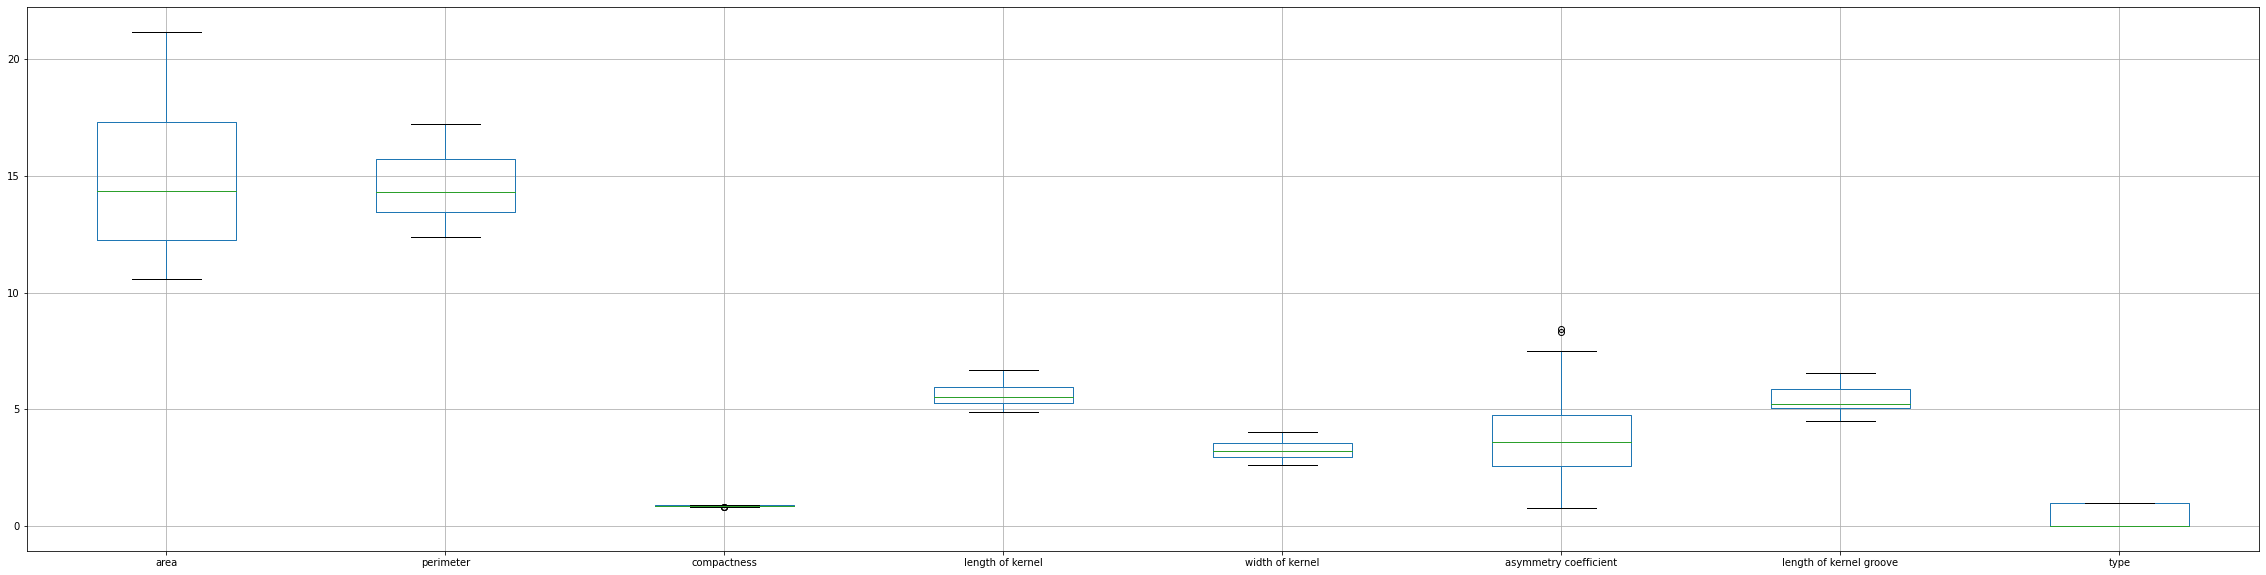

In [142]:
df.loc[:,'area':'type'].boxplot(figsize=(40,10))
plt.show()

The 3rd 'compactness' and 6th 'asymmetry coefficient' have outliers 

In [143]:
df['asymmetry coefficient'].describe()

count    210.000000
mean       3.700201
std        1.503557
min        0.765100
25%        2.561500
50%        3.599000
75%        4.768750
max        8.456000
Name: asymmetry coefficient, dtype: float64

In [144]:
#def up_low_lim(describe_all):
    #for feat in df.columns:
   #     describe = describe_all[feat]
  #      describe_all['lower_lim'] = ( ( describe['75%'] - describe['25%'] ) * - 1.5 ) + describe['25%'] 
 #       describe_all['upper_lim'] = ( ( describe['75%'] - describe['25%'] ) * 1.5 ) + describe['75%'] 
#        return describe_all

In [145]:
def up_low_lim(describe):
    lower_lim = ( ( describe['75%'] - describe['25%'] ) * - 1.5 ) + describe['25%'] 
    upper_lim = ( ( describe['75%'] - describe['25%'] ) * 1.5 ) + describe['75%'] 
    return lower_lim, upper_lim

In [146]:
ac_desc = df['asymmetry coefficient'].describe()
lower_lim, upper_lim = up_low_lim(ac_desc) 
df['asymmetry coefficient'][df['asymmetry coefficient']> upper_lim].count()

2

In [147]:
c_desc = df['compactness'].describe()
lower_lim, upper_lim = up_low_lim(c_desc) 
df['compactness'][df['compactness']> upper_lim].count()
df['compactness'][df['compactness']< lower_lim].count()

3

In [148]:
names_all = [c for c in df if c not in ['type']]
names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [149]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [150]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [151]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [152]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Grid search 1

In [153]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'linear'}


## Grid search 2

In [154]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


In [155]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [156]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [157]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

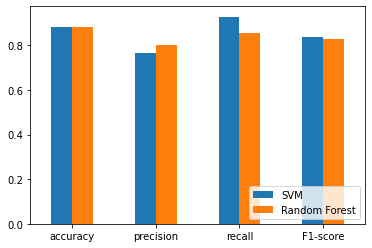

In [158]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

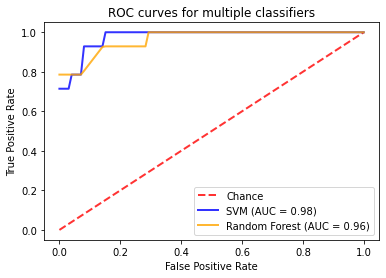

In [159]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In [160]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [161]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Conclusion 
As a binary classifier can only separate between two classes and our data set has three, one class had to be set to one and the other two combined in to class ‘0’. You would then need a second and third model to classify the other two. You could just have a second model but then if it was negative on the first two you would presume its positive on the thirds but it might not actually show positive on the third and the model would not be able to predict and outcome for that instance. 

The Random Forest had higher accuracy and precision, where accuracy is the proportion of correct predictions out of all predictions and precision is the true positives out of all predicted positives. The recall of the SVM and Random Forest was similar, recall is the proportion of true positives out of all actual positives. The Random Forest also had a higher F1-score (harmonic mean of precision and recall). 

Let’s assume the use case of sorting seeds for industrial farming, if the model gives a false positive the wrong plant grows amongst the harvest. Therefore, we want to use the model which reduces the numbers of false positives and therefore has the highest precision. 


In [189]:
svm_T1 = svm.SVC(probability=True)


param_dist = {
    'C': np.linspace(1e-6 ,1e+6, num=20), # Real(1e-2, 1e+2, prior='log-uniform'), #, prior='log-uniform'),# np.linspace(0.00001 ,1, num=5),
    'kernel': ['rbf','linear'], #,'poly'], # Takes too long to seach them all linear','rbf','poly'],
    #'degree': [3,5,7],
    'gamma': np.linspace(0.5 ,2, num=5)
}
bayes_search = BayesSearchCV(svm_T1, param_dist, cv=5, scoring='accuracy')
bayes_search.fit(X_train, y_train)

# Print the best parameters and accuracy score
print('Bayesian Optimization Search - Best Parameters:', bayes_search.best_params_)
print('Bayesian Optimization Search - Best Accuracy:', bayes_search.best_score_)

# store the best params and best model for later use
SVM_B_best_params = bayes_search.best_params_
SVM_B_best_model = bayes_search.best_estimator_

SVM_B_accuracy, SVM_B_precision, SVM_B_recall, SVM_B_f1_score, SVM_B_tpr, SVM_B_auc = evaluate_model(X_test, y_test, SVM_B_best_model)

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Bayesian Optimization Search - Best Parameters: OrderedDict([('C', 52631.578948315786), ('gamma', 0.5), ('kernel', 'linear')])
Bayesian Optimization Search - Best Accuracy: 0.95222816399287


In [216]:
# define network topology
mlp = MLPClassifier()
# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}
#start time 
stgm = time.time()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# End time 
etgm = time.time()

# get the execution time
print('Grid Search Execution time:', etgm - stgm, 'seconds')

mlp_model = grid_search.best_estimator_
test_score_mlp = mlp_model.score(X_test, y_test)


# Print the best parameters and accuracy score
print('Grid Search - Best Parameters:', grid_search.best_params_)
print('Grid Search - Best Accuracy:', grid_search.best_score_)    
print(f'Grid Search - Test Accuracy: {test_score_mlp:.6f}')  

MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, mlp_model)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 329 out of 360 | elapsed:    2.4s remaining:    0.1s


Grid Search Execution time: 2.9474287033081055 seconds
Grid Search - Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (300,), 'learning_rate': 'constant', 'solver': 'adam'}
Grid Search - Best Accuracy: 0.9163992869875223
Grid Search - Test Accuracy: 0.880952


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    2.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [236]:
 # create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knc', KNeighborsClassifier())])

#knc =  KNeighborsClassifier()

param_grid = {
    'knc__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16] # np.linspace(1,20,num=20)
    }

CV_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
CV_search.fit(X_train, y_train) #training happens here!

print("Best CV score during training = %0.3f:" % CV_search.best_score_)
print("Best parameters: ", CV_search.best_params_)

# store the best params and best model for later use
KNC_best_params = CV_search.best_params_
KNC_best_model = CV_search.best_estimator_

KNC_accuracy, KNC_precision, KNC_recall, KNC_f1_score, KNC_tpr, KNC_auc = evaluate_model(X_test, y_test, KNC_best_model)

Best CV score during training = 0.934:
Best parameters:  {'knc__n_neighbors': 5}


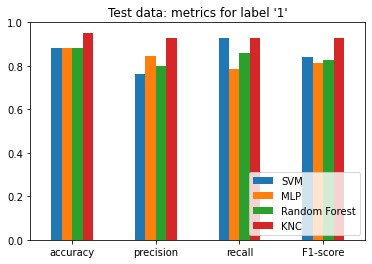

In [237]:
KNC_metrics = np.array([KNC_accuracy, KNC_precision, KNC_recall, KNC_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'MLP': MLP_metrics, 'Random Forest': RF_metrics, 'KNC': KNC_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.title("Test data: metrics for label '{}'".format(1))
plt.show()

### Conclusion Task 3
It is clear that the KNC model performed best, our critical scoring method was the percison which KNC outperformed the others on. 

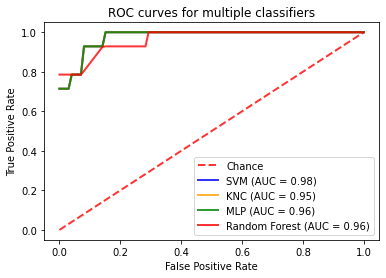

In [238]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='orange', label='KNC (AUC = %0.2f)' % (KNC_auc), alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='red', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()